In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

<h2><b>Sample view of Data </h2></p>

In [3]:
train_data.head()

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


<p><b> No of rows,customers with category '1' and positivity rate</b> </p>

In [4]:
nrows=train_data.shape[0]
npos=sum(train_data['customer_category']>0)
print("No of Positives for Customer Category: "+str(npos)+"  || Total no of rows : "+str(nrows))
print("positivity Rate: "+str(100*(npos/nrows))+" %")
pos_rate=100*(npos/nrows)

No of Positives for Customer Category: 1295  || Total no of rows : 10738
positivity Rate: 12.059973924380705 %


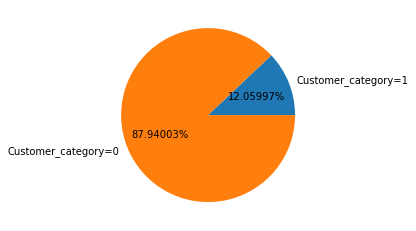

In [5]:
label=['Customer_category=1','Customer_category=0']
plt.pie([pos_rate,100-pos_rate],labels=label,autopct='%1.5f%%')
plt.show()

<h2><b>Function for Data <i> PreProcessing<i></b></h2>

In [6]:
def process(data):
    data=data.fillna(data.mode())
    data.head()

    cust_act_seg_dum=pd.get_dummies(data['customer_active_segment']+'_cust_act_seg')
    X1_dum=pd.get_dummies(data['X1']+'_X1')
    X1_dum
    data=pd.concat([data,X1_dum,cust_act_seg_dum],axis=1)
    data=data.drop(['X1','customer_active_segment'],axis=1)
    return data

In [7]:
train_data=process(train_data)
test_data=process(test_data)

In [8]:
X_train=train_data.drop(['customer_category','customer_id'],axis=1)
Y_train=train_data['customer_category']
customer_id=test_data['customer_id']
X_test=test_data.drop(['customer_id'],axis=1)

In [9]:
#imporing XGB Classifier for Classification
from xgboost import XGBClassifier

In [10]:
model=XGBClassifier()
model.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<h2>Finding Feature Importance </h2>

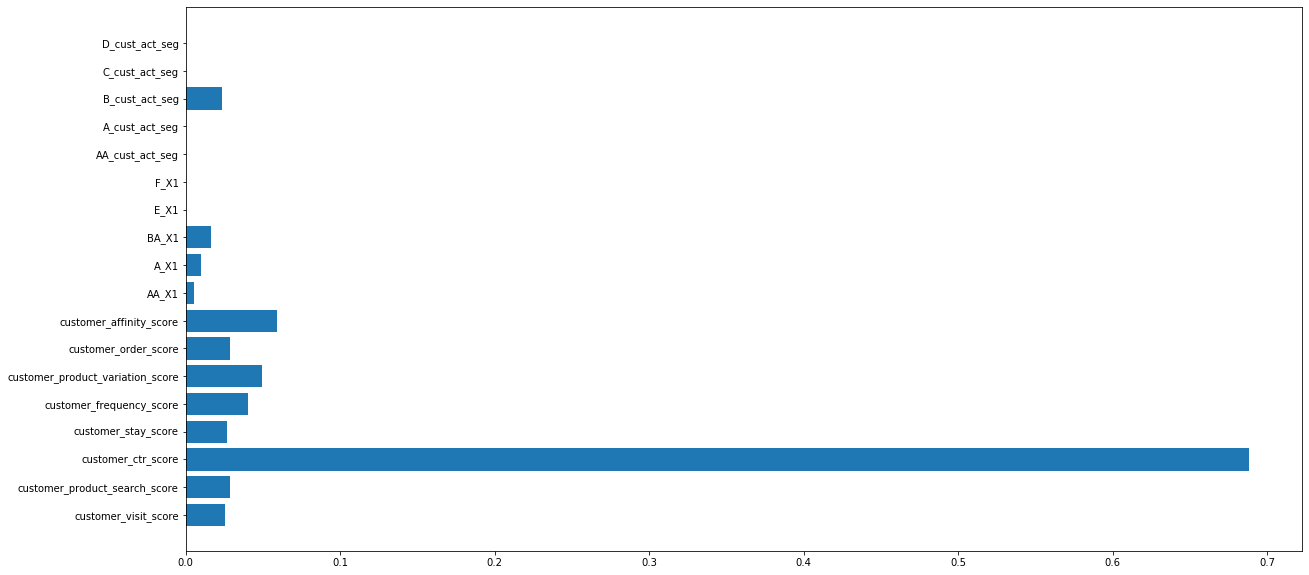

In [11]:
value=model.feature_importances_
name=X_train.columns
fig = plt.figure(figsize = (20, 10))
plt.barh(name, value)
plt.show()

In [12]:
pd.DataFrame({'Name':name,'value':value}).sort_values(by='value', ascending=False)

,Name,value
2,customer_ctr_score,0.688096
7,customer_affinity_score,0.059165
5,customer_product_variation_score,0.049611
4,customer_frequency_score,0.039986
1,customer_product_search_score,0.028641
6,customer_order_score,0.028390
3,customer_stay_score,0.026790
0,customer_visit_score,0.025478
15,B_cust_act_seg,0.023131
10,BA_X1,0.016005


<b><p> Now we Will be Removing these columns having a less significance , it may reduce noise and overfitting<p><b>

In [13]:
drop_these=['D_cust_act_seg','C_cust_act_seg','A_cust_act_seg','AA_cust_act_seg','F_X1','E_X1']
X_train=X_train.drop(drop_these,axis=1)
X_test=X_test.drop(drop_these,axis=1)

<b><p> Finding Covariance using Heatmap<p><b>

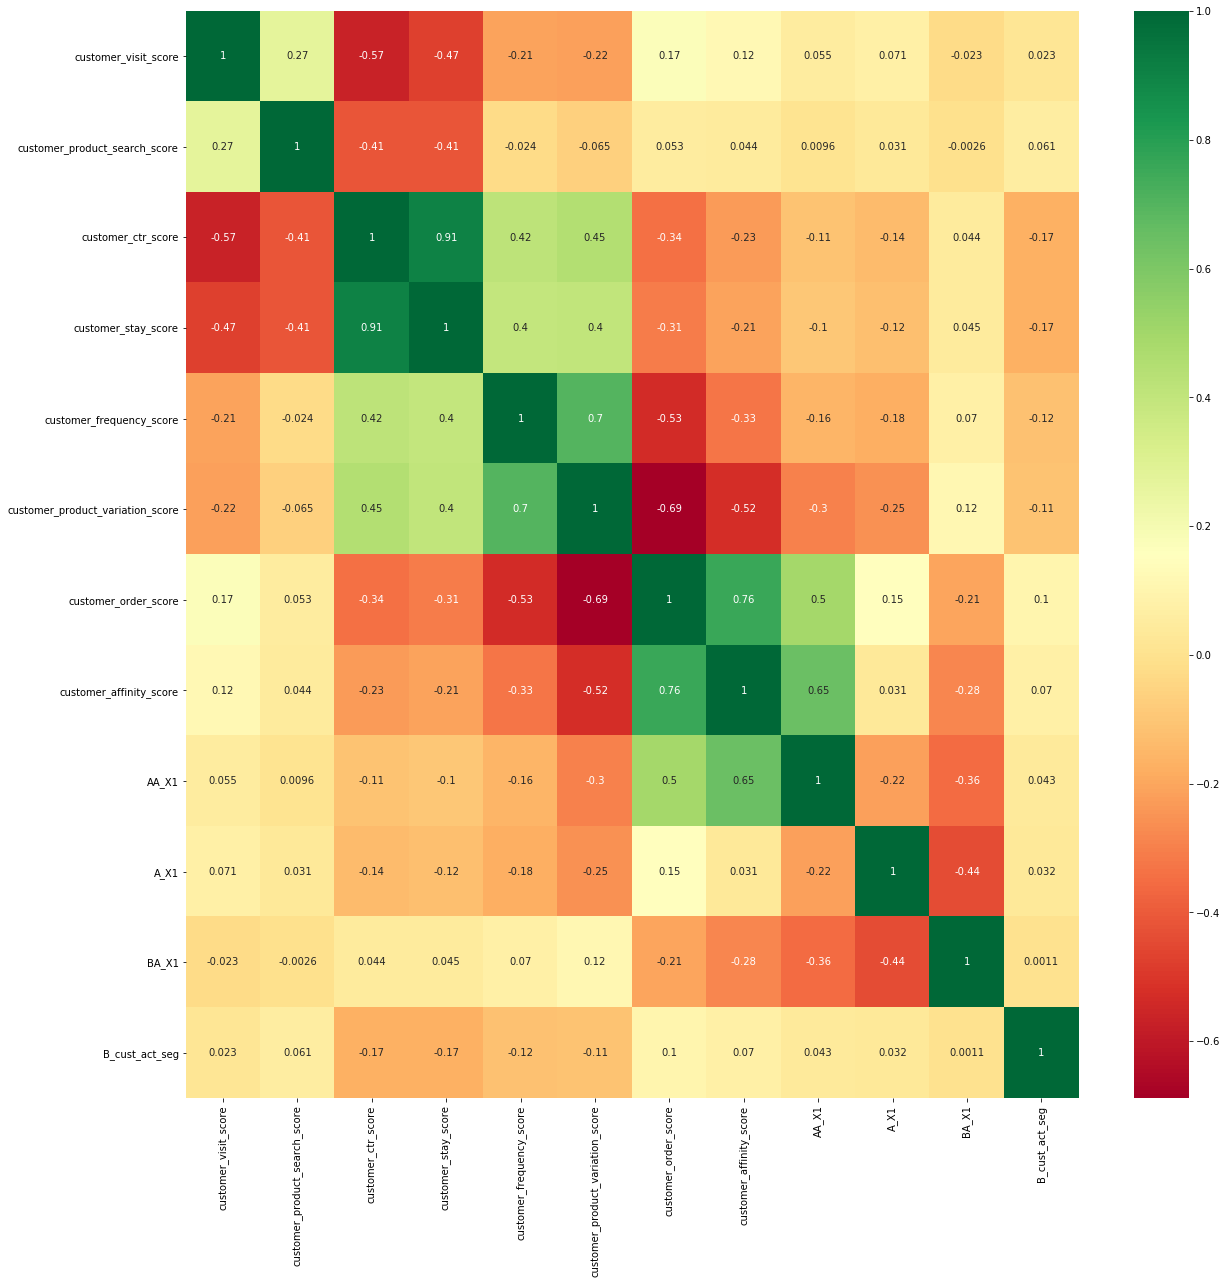

In [14]:
import seaborn as sns
corrmat = X_train.corr()
corrmat
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<p><b>(customer_stay_score and customer_ctr_score) and (customer_order_score and customer_affinity_score) have a high value of Covariance so one of them may be removed<b><p>

In [15]:
drop_these=['customer_stay_score','customer_order_score']
X_train=X_train.drop(drop_these,axis=1)
X_test=X_test.drop(drop_these,axis=1)   ## The data to test and upload the files

In [16]:
model.fit(X_train, Y_train)
res=model.predict(X_test)
op=pd.DataFrame()
op['customer_id']=customer_id
op['customer_category']=res

In [17]:
op.customer_category.sum()

353

<b><p>Finding Out the Best Parameters for Algorithm<p><b>

In [18]:
from sklearn.model_selection import GridSearchCV
parameter={'learning_rate':[0.07,0.08,0.2,0.3,0.5],'max_depth':[4,5,6,7,8],'min_samples_split':[5,6,7,8]}
clf = XGBClassifier()
model=GridSearchCV(estimator=clf,param_grid=parameter,cv=5,verbose=10,n_jobs=-1)
#model.fit(X_train, Y_train)

In [19]:
model=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1)

<b><p>Function to Compute Cross-Validation Score<p><b>

In [20]:
def ComputeScore(X_train,Y_train,model):
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import precision_score
    scoring = ['precision']
    scores = cross_validate(model,X_train,Y_train,scoring=scoring)
    return scores['test_precision'].mean()

In [21]:
ComputeScore(X_train,Y_train,model)

0.9411712312128205

<b><p> Now Since data is bias towards 0 thus we will eliminate some of the zeros<p><b>

In [22]:
mydata=pd.concat([X_train,Y_train],axis=1)
mydata.head(3)

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_frequency_score,customer_product_variation_score,customer_affinity_score,AA_X1,A_X1,BA_X1,B_cust_act_seg,customer_category
0,13.168425,9.447662,-0.070203,0.436956,4.705761,7.959503,0,0,0,0,0
1,17.092979,7.329056,0.153298,0.380340,4.205138,17.517381,0,1,0,0,0
2,17.505334,5.143676,0.106709,0.417648,4.479070,12.595155,0,0,1,0,0


<b><p>Out of all data lets remove  data where customer_category=0 such that the positivity rate =20%<p><b>

In [23]:
pos=mydata[mydata['customer_category']==1]
neg=mydata[mydata['customer_category']==0]
neg=neg.head(5000)
new_data=pd.concat([neg,pos])
new_data=new_data.sample(frac=1)
new_data.head(3)

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_frequency_score,customer_product_variation_score,customer_affinity_score,AA_X1,A_X1,BA_X1,B_cust_act_seg,customer_category
5336,20.158215,7.261184,0.031453,0.256881,5.305296,21.970914,0,1,0,1,0
5385,12.124926,4.259106,0.164639,0.226283,3.793131,100.504600,0,0,0,0,0
206,13.706409,5.719688,-0.031575,0.476643,4.569610,23.713784,0,0,1,0,0


In [24]:
nrows=new_data.shape[0]
npos=sum(new_data['customer_category']>0)
print("No of Positives for Customer Category: "+str(npos)+"  || Total no of rows : "+str(nrows))
print("positivity Rate: "+str(100*(npos/nrows))+" %")
pos_rate=100*(npos/nrows)

No of Positives for Customer Category: 1295  || Total no of rows : 6295
positivity Rate: 20.57188244638602 %


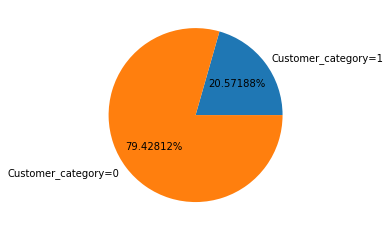

In [25]:
label=['Customer_category=1','Customer_category=0']
plt.pie([pos_rate,100-pos_rate],labels=label,autopct='%1.5f%%')
plt.show()

In [27]:
X=mydata.drop(['customer_category'],axis=1)
Y=mydata['customer_category']
ComputeScore(X,Y,model)

0.9411712312128205

<b><p> So there is not much difference in model , So we can go with with our original data<b><p>

In [105]:
model.fit(X_train,Y_train)
result=model.predict(X_test)
result
op_table=pd.DataFrame({'customer_id':customer_id,'customer_category':result})

In [109]:
op_table.to_csv('Output.csv',index=False)

<h2>Visualize the Data for insights in modeling for a proper statregy<h2>

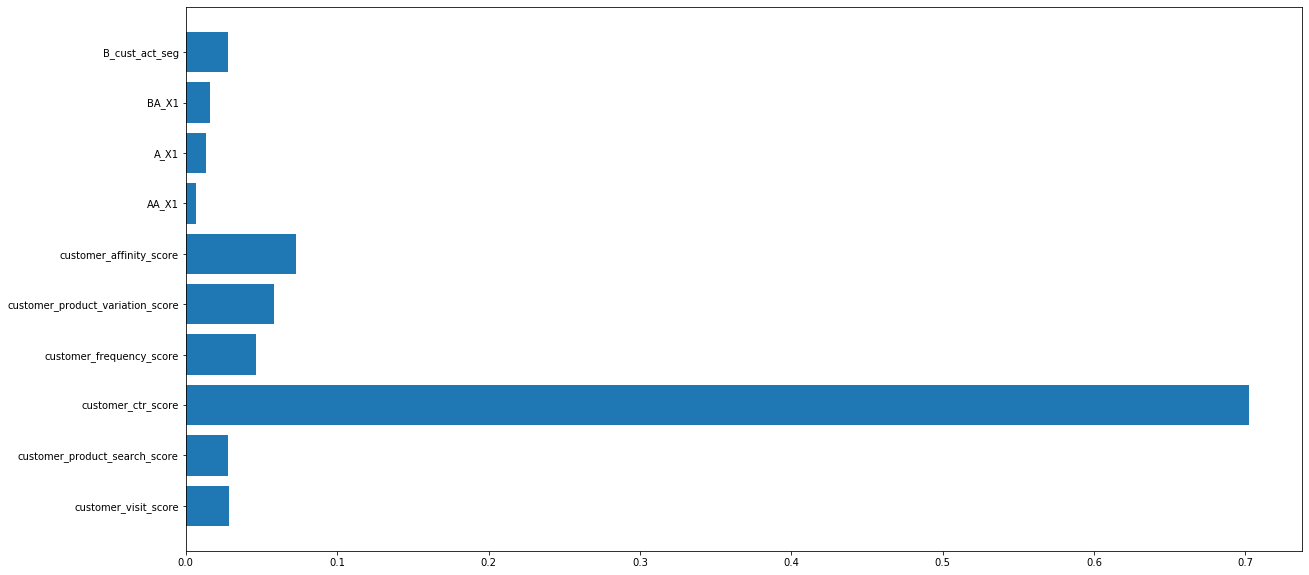

In [112]:
value=model.feature_importances_
name=X_train.columns
fig = plt.figure(figsize = (20, 10))
plt.barh(name, value)
plt.show()

In [127]:
feature_table=pd.DataFrame({'Name':name,'value':value}).sort_values(by='value', ascending=False)
feature_table

,Name,value
2,customer_ctr_score,0.702177
5,customer_affinity_score,0.072987
4,customer_product_variation_score,0.058261
3,customer_frequency_score,0.046343
0,customer_visit_score,0.028206
1,customer_product_search_score,0.028052
9,B_cust_act_seg,0.027807
8,BA_X1,0.015759
7,A_X1,0.013376
6,AA_X1,0.007033


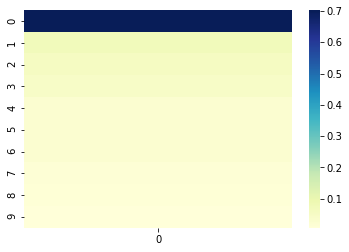

In [139]:
X_train
Y_train
mydata=pd.concat([X_train,Y_train],axis=1)
mydata['index_no']=np.arange(len(mydata))

In [140]:
mydata.head()

,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_frequency_score,customer_product_variation_score,customer_affinity_score,AA_X1,A_X1,BA_X1,B_cust_act_seg,customer_category,index_no
0,13.168425,9.447662,-0.070203,0.436956,4.705761,7.959503,0,0,0,0,0,0
1,17.092979,7.329056,0.153298,0.380340,4.205138,17.517381,0,1,0,0,0,1
2,17.505334,5.143676,0.106709,0.417648,4.479070,12.595155,0,0,1,0,0,2
3,31.423381,4.917740,-0.020226,0.778130,5.055535,4.795073,0,0,0,0,0,3
4,11.909502,4.237073,0.187178,0.162067,3.445247,56.636326,1,0,0,0,0,4


<b><p>Scatter Plot Signifying the distinction between customer_ctr_score and customer_category , index_no has no significance it is just used to plot<p><b>
* Notice higher the customer_ctr_score more we get customer_category=1

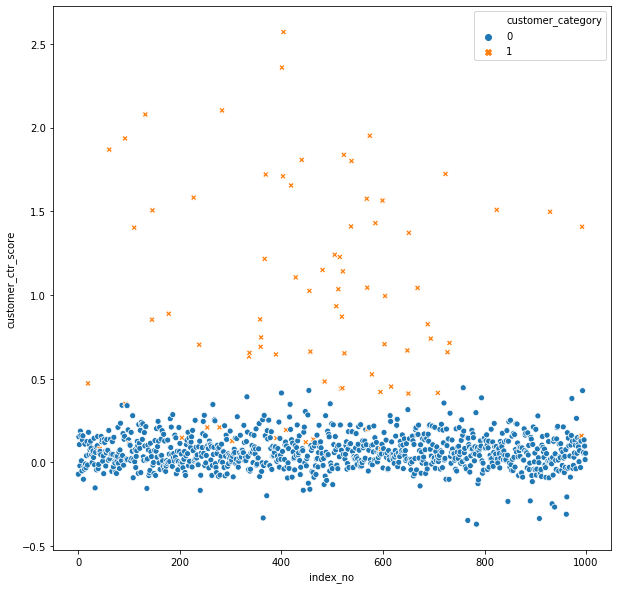

In [148]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=mydata.head(1000), x="index_no", y="customer_ctr_score", hue="customer_category",style="customer_category")

<b><p>Scatter Plot Signifying the distinction between customer_affinity_score and customer_category , index_no has no significance it is just used to plot<p><b>
* Notice lower the customer_affinity_score more we get customer_category=1

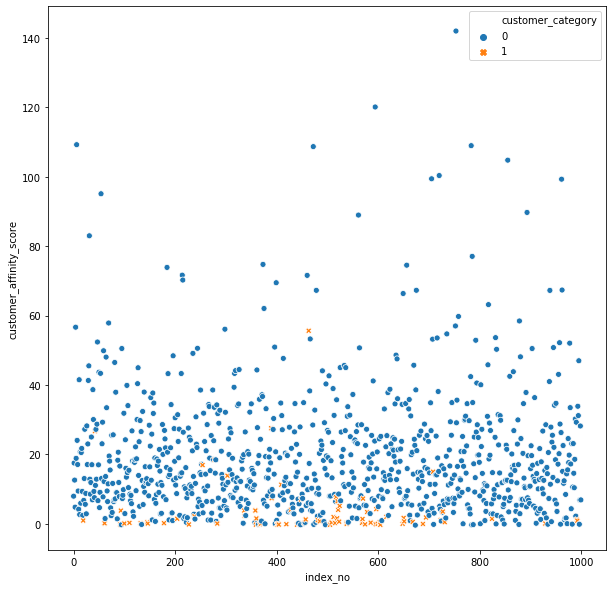

In [153]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=mydata.head(1000), x="index_no", y="customer_affinity_score", hue="customer_category",style="customer_category")

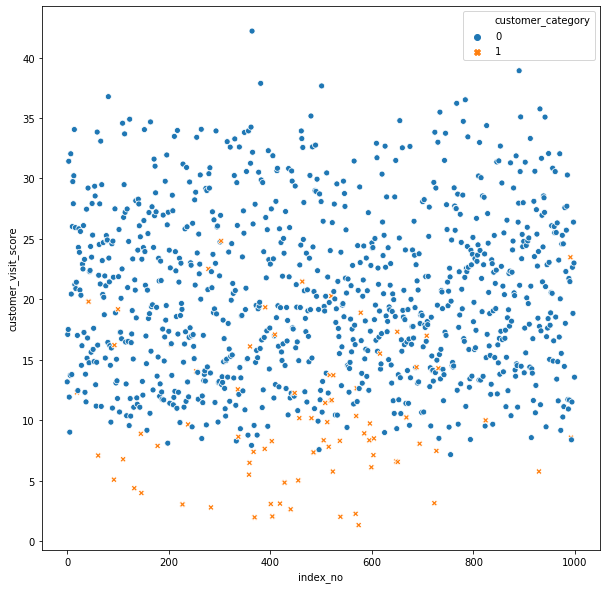

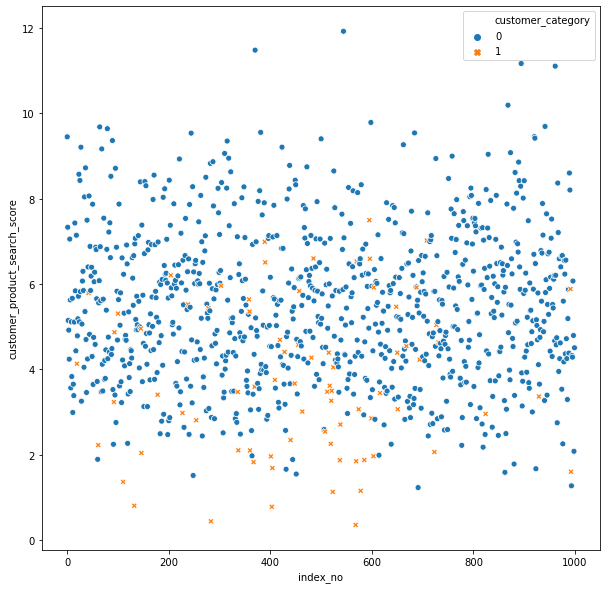

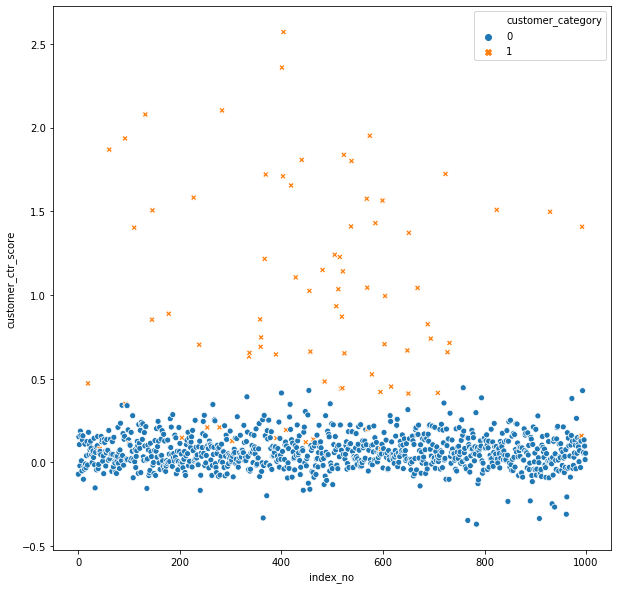

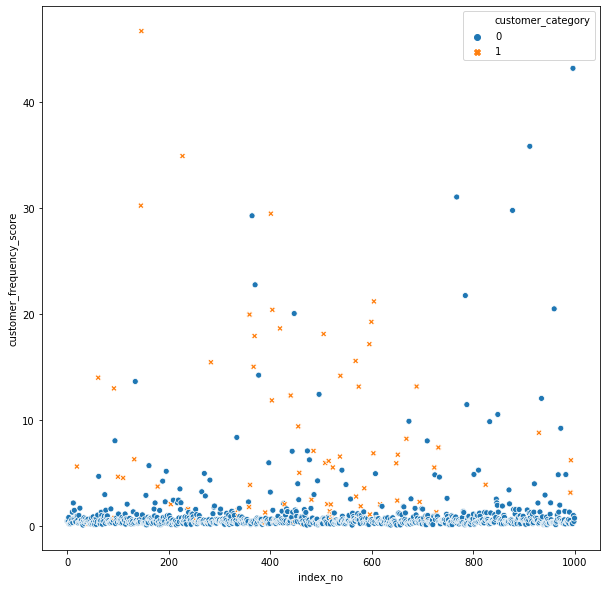

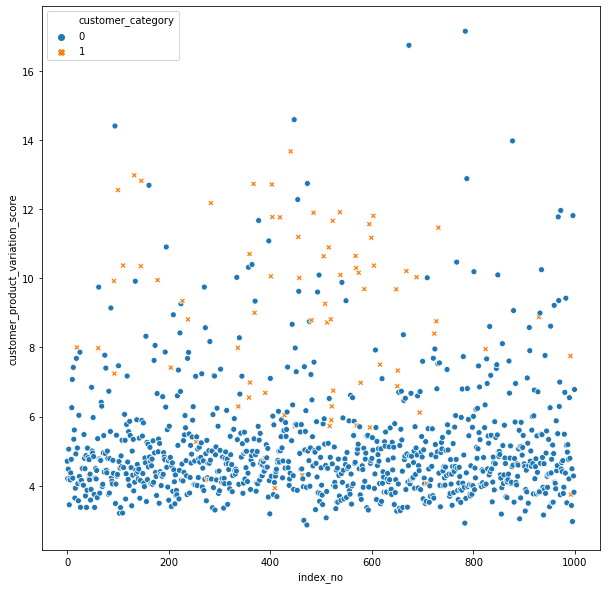

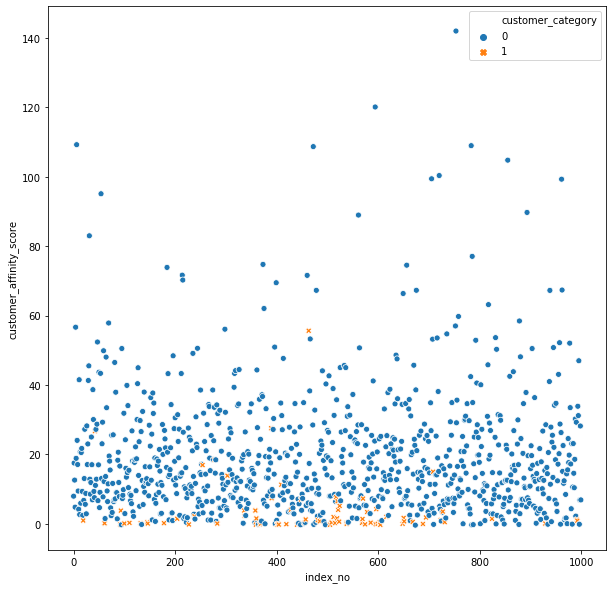

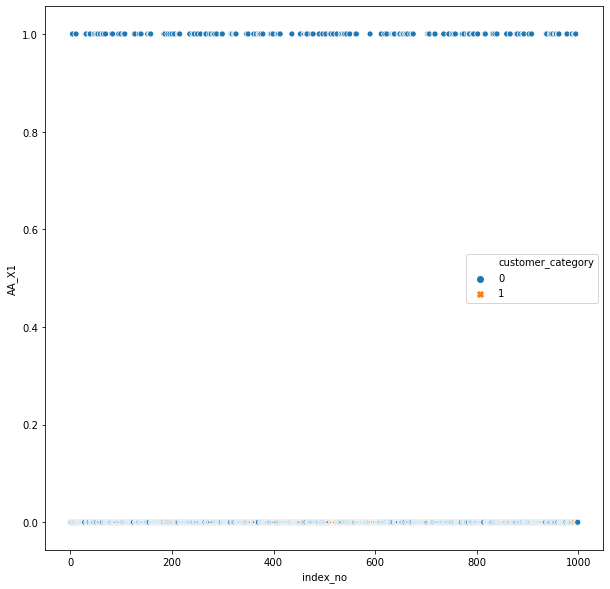

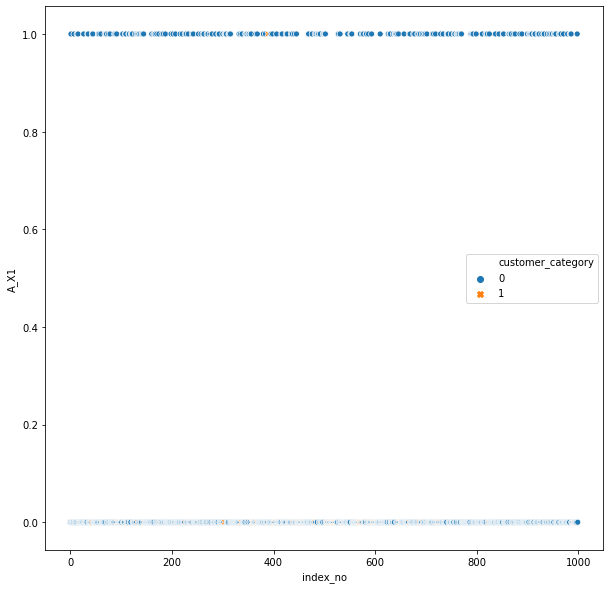

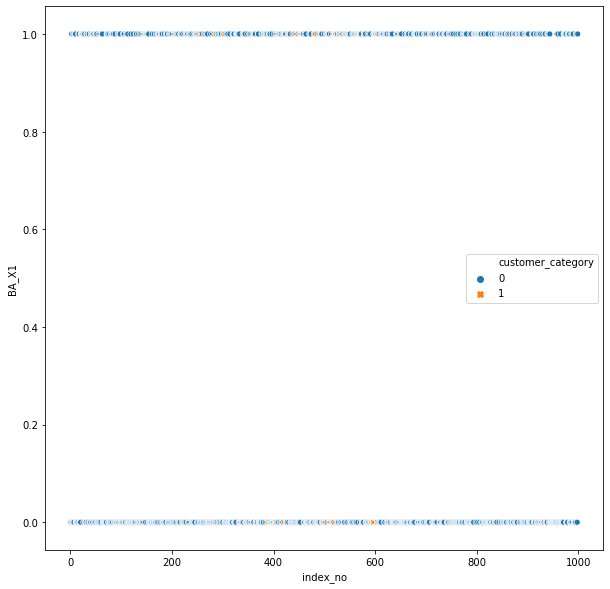

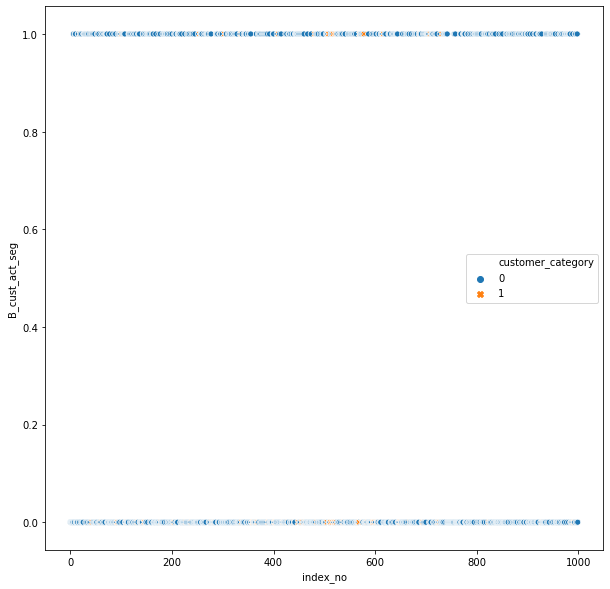

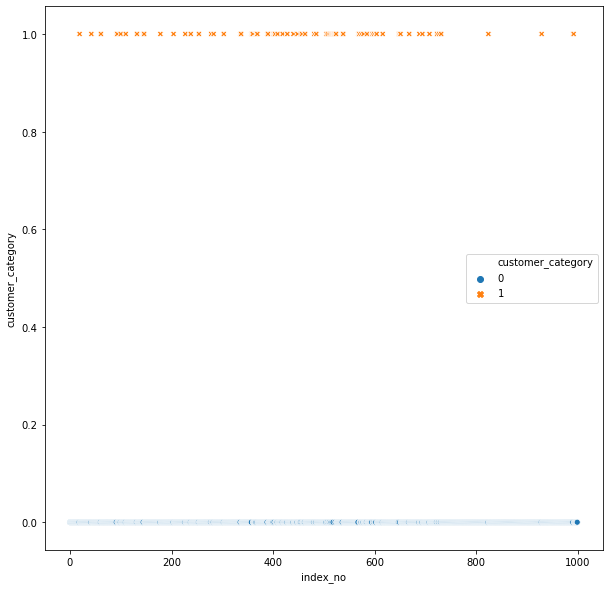

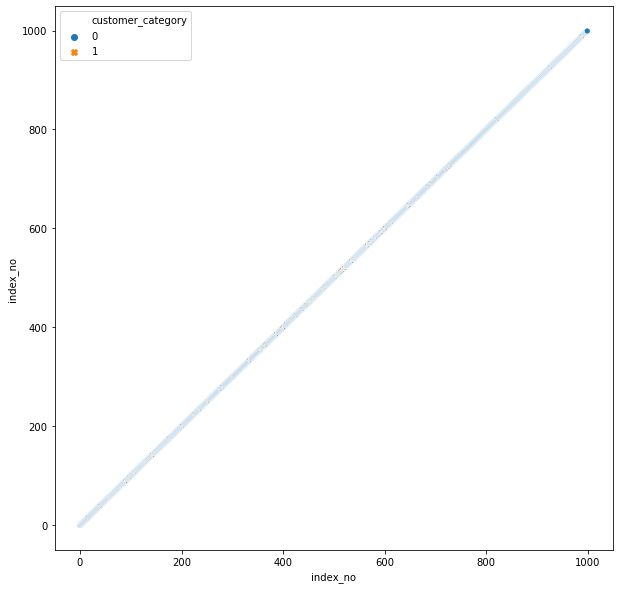

In [228]:
for i in mydata.columns:
    plt.figure(figsize=(10,10))
    sns.scatterplot(data=mydata.head(1000), x="index_no", y=i, hue="customer_category",style="customer_category")

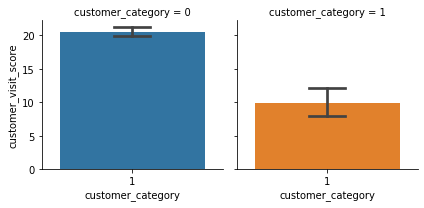

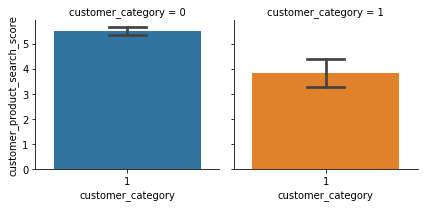

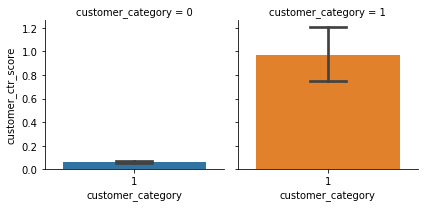

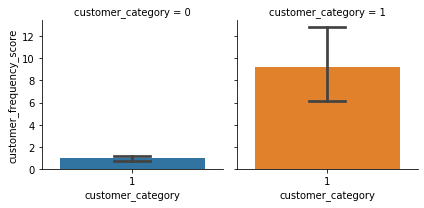

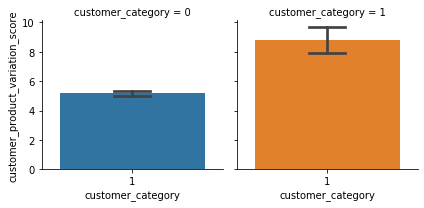

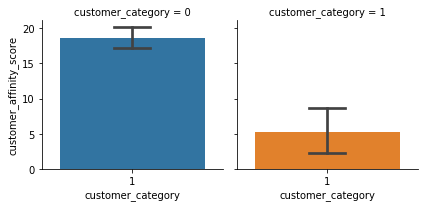

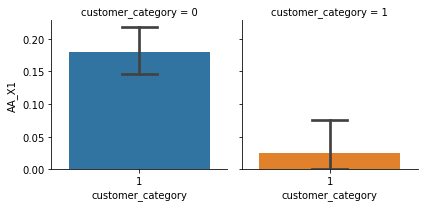

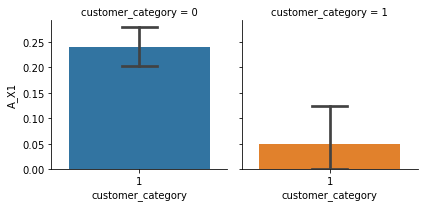

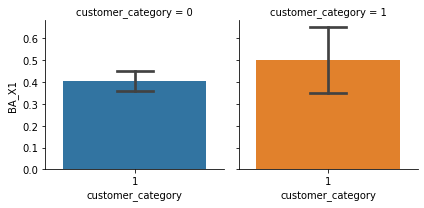

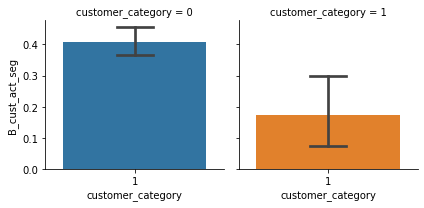

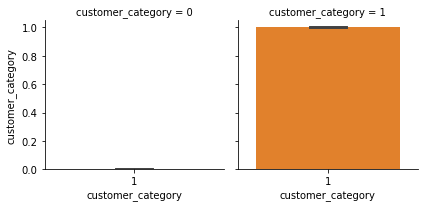

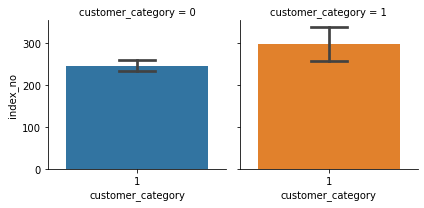

In [225]:
for i in mydata.columns:
    g = sns.FacetGrid(mydata.head(500), col="customer_category",hue='customer_category')
    g.map(sns.barplot,'customer_category',i,capsize=.2)